# Getting started with the signal_generator package

## Goal
This notebook will introduce the basic workflow of the package. 

## Generating a signal
The signals are generated based on the time evolution of the central
frequency of the individual modes that make up the signal.
Examples of how this can be done will be provided. 

## Helper functions
Some plotting functions are provided here, they are not part of the
package, but they are useful.


In [1]:
#imports and setup for plotting and making plots pretty
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator
matplotlib.rc('text', usetex='False')

matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
matplotlib.rcParams.update({'pgf.rcfonts' : True})

matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 1.5
matplotlib.rcParams['xtick.minor.size'] = 6
matplotlib.rcParams['xtick.minor.width'] = 1

matplotlib.rcParams['ytick.major.size'] = 8
matplotlib.rcParams['ytick.major.width'] =1.5
matplotlib.rcParams['ytick.minor.size'] = 6
matplotlib.rcParams['ytick.minor.width'] = 1

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [2]:
#Plotting functions
def spectrogram_full(t,h):
    from scipy.fftpack import fft
    from scipy import signal
    N = 2*512
    nf = 2*N
    dt = 0.05/(nf)
    freq = np.fft.fftfreq(nf, d=dt)

    ffpeuq = interp1d(t, h)
    tshift = min(t)
    fnyq = max(freq)
    bl, al = signal.butter(2, 1200.0/fnyq,'low')
    bh, ah = signal.butter(2, 25.0/fnyq,'high')
    window = signal.kaiser(nf,2.5)
    window = signal.blackman(nf)
    t2 = np.linspace(tshift,0.05+tshift,nf)
    tarr = []
    fttm = []
    j = 0
    while(max(t2) < max(t)):
        amp = ffpeuq(t2)
        amp1 = signal.filtfilt(bh, ah, amp)
        amp2 = signal.filtfilt(bl, al, amp1)
        amp3 = amp2*window
        fftamp  = (np.abs(fft(amp3))[0:N]**2) /np.sum(window)**2
        fttm.append([])
        fttm[j] = fftamp
        tarr.append((max(t2)+min(t2))*0.5)
        tshift = tshift + 0.001
        t2 = np.linspace(tshift,0.05+tshift,nf)
        j = j+1
    rt = fttm,freq[0:N],tarr
    return rt

def plot_spectrogram(t,h,filename="specs.png",modes=None):
    t = t - min(t)
    jet = cm = plt.get_cmap('jet')
    v = np.linspace(-6,0,50)
    f1,ax=plt.subplots(figsize=(20,10),ncols=1,nrows=1,sharex="row",sharey="row")
    ffc,f,t1=spectrogram_full(t,h)
    ft=np.log10((np.transpose(ffc)**2+1e-13))
    cb=ax.contourf(np.array(t1),f,ft,v,cmap=jet,extend="both")
    f1.subplots_adjust(hspace=0.,wspace=0.0)
    ax.set_ylim([25,1250])
    ax.set_xlim([min(t1),max(t1)])
    ax.set_yticks([100,250,400,550,700,850,1000,1150])
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(3))
    ax.set_xlabel(r'$\mathrm{Time\,[ms]}$')
    ax.set_ylabel(r'$\mathrm{Frequency\,[Hz]}$')
    
    if(modes):
        for key in modes.keys():
            ax.plot(t,modes[key],'--',lw=3.5,c="black")

    f1.colorbar(cb,ax=ax,ticks=[0,-1,-2,-3,-4,-5,-6],pad=0.007,aspect=30)
    plt.savefig(filename,bbox_inches='tight')

def plot_signal(t,hx,hp,filename="amps.png"):
    f1,ax=plt.subplots(figsize=(20,10),ncols=1,nrows=2,sharex="row",sharey="row")
    f1.subplots_adjust(hspace=0.,wspace=0.0)
    ax[0].plot(t,hx)
    ax[0].set_ylim([-1.5,1.5])
    ax[0].set_xlim([min(t),max(t)])
    ax[0].set_yticks([-1,-0.5,0,0.5,1])
    ax[0].xaxis.set_minor_locator(AutoMinorLocator(4))
    ax[0].yaxis.set_minor_locator(AutoMinorLocator(3))
    ax[0].set_ylabel(r'$\mathrm{Amplitude}$') 
    ax[1].set_xlabel(r'$\mathrm{Time\,[ms]}$')
    
    ax[1].plot(t,hp)
    ax[1].set_ylim([-1.5,1.5])
    ax[1].set_xlim([min(t),max(t)])
    ax[1].set_yticks([-1,-0.5,0,0.5,1])
    ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
    ax[1].yaxis.set_minor_locator(AutoMinorLocator(3))
    ax[1].set_ylabel(r'$\mathrm{Amplitude}$') 
    plt.savefig(filename,bbox_inches='tight')
    

# The main part of the notebook starts here.

## Part 1:
In the first part, we demonstrate how to generate the signal when the modes are specified
as arrays which contain the central frequency of the mode as a function of time

## Part 2: 
In the second part, we demonstrate how to use the inbuilt modes and compare the results with data from a
2D simulation. This part requires you to download the
`s20_reduced.dat` file found in the GitHub repository.

In [3]:
#import the package
import synthgrav
from synthgrav import mode_list 
#Import the mode_list here to
#demonstrate something later, but its not
#needed for normal operation


In [4]:
#Define two functions that will be used to create modes
#later on. These are chosen somewhat at random.
def polynomial_mode(time_array):
    start_freq = 300
    end_freq = 1000
    end_time = 0.6

    a = (end_freq - start_freq) / end_time**2
    b = 0
    c = start_freq

    return a * time_array**2 + b * time_array + c

def constant_mode(time_array,k=150):
    return np.ones(len(time_array))*k


Text(0, 0.5, 'mode frequency [Hz]')

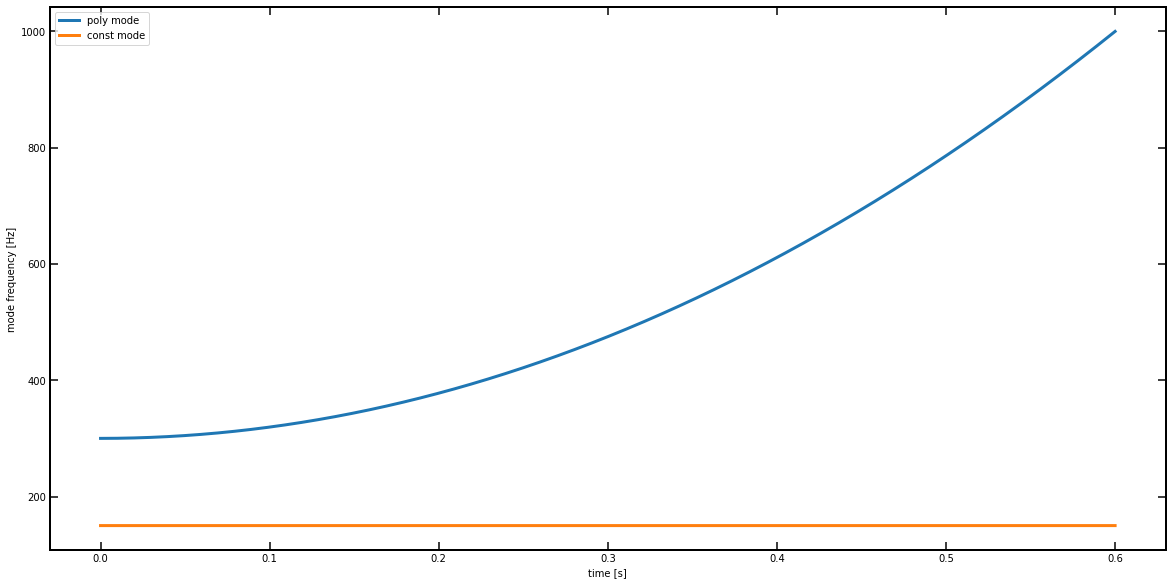

In [6]:
#Define our time array and sample the modes.
t = np.linspace(0,0.6,4000) #Here we use 3000 samples

modes = {"poly" : polynomial_mode(t), "const" : constant_mode(t)}
pol = {"poly" : ["linear",0.3,],"const" : ["unpolarised",0]}

#Plot the central frequency of the modes
f,ax=plt.subplots(figsize=(20,10),ncols=1,nrows=1,sharex="row",sharey="row")
ax.plot(t,modes['poly'],lw=3,label='poly mode')
ax.plot(t,modes['const'],lw=3,label='const mode')
plt.legend()
ax.set_xlabel("time [s]")
ax.set_ylabel("mode frequency [Hz]")

## A note on the sampling frequency
It is important to choose a sampling rate that is appropriate for the signal you aim to generate.
Under-resolving the signal in frequency space will result in artefacts. One potential issue arises when
the individual pulses comprising the modes are generated. They are generated as coloured noise with a given
PSD. The default PSD is a Gaussian, which for a central frequency $f_c$ is generated as:

$\mathrm{PSD}(f) \sim e^{(f_c-f)^2/2\sigma}$.

If the frequency resolution is poor, $(f_c-f)$ can become large for all frequencies, and the PSD effectively becomes zero. The computational cost grows as a function of time samples, so the user is advised to perform tests and find the appropriate sampling rate. We do not set default requirements because it is highly problem dependent. 

In [7]:
#Create the signal instance and inspect the modes contained within it.
s = synthgrav.Signal(time=t,modes=modes,mode_kwargs = {},polarisation=pol)
s.modes

{'poly': array([ 300.        ,  300.00004377,  300.00017509, ...,  999.30000004,
         999.64995625, 1000.        ]),
 'const': array([150., 150., 150., ..., 150., 150., 150.])}

In [8]:
s.generate_signal() #Generate the signal

### The signal
After generating a signal (s), you will find the two independent polarisation modes in `s.signal[0]` 
and `s.signal[1]`. The two components correspond to $h_\times$ and $h_+$. The polarisation can be set to three options:
- unpolarised: Two independent signals will be constructed
- linear: One component will be set to zero; it is always possible to find a frame so that $h_\times$ or $h_+$ is zero. 
- elliptical: we assume that the Fourier-transform of the two modes satisfy  $h_\times(f) = K h_+(f)$, where K is a constant determined for each time step. This corresponds to a phase offset of zero. 

You always use the polarisation value, but it is only used for elliptical, and it is allowed to vary with time.

Note: The user is, in principle, free to determine which polarisation mode `s.signal[0]` and `s.signal[1]` corresponds to.

# Plotting
Let's look at the signal and make sure it looks reasonable.
The tapering at the beginning is due to the default signal weight, designed to
mimic the behaviour seen in core-collapse signals. 
It can be changed by providing
`signal_weight` and `mode_weight` when initiating the signal. 
The former is a global weight applied to the total
signal, and the latter represents weights applied to each independent mode.

By overplotting the central mode frequencies, calculated above, on the spectrogram, we can clearly
see that the signal has the correct spectral properties.

Note: For the spectrograms, we divide by 0.2; this is only to make the plot look better and is not important.

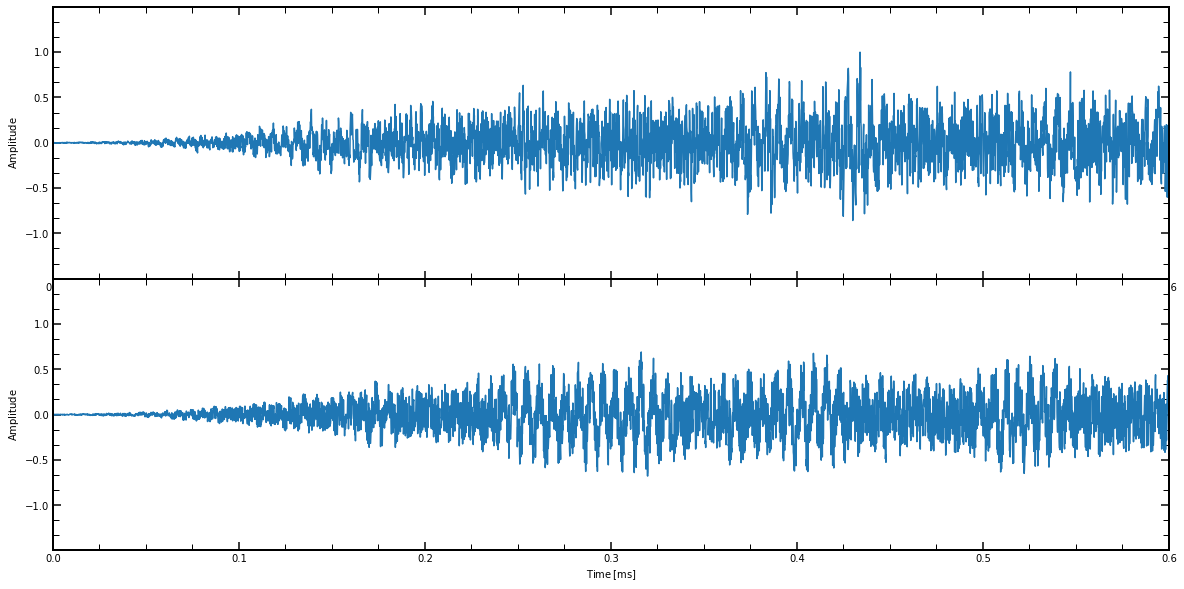

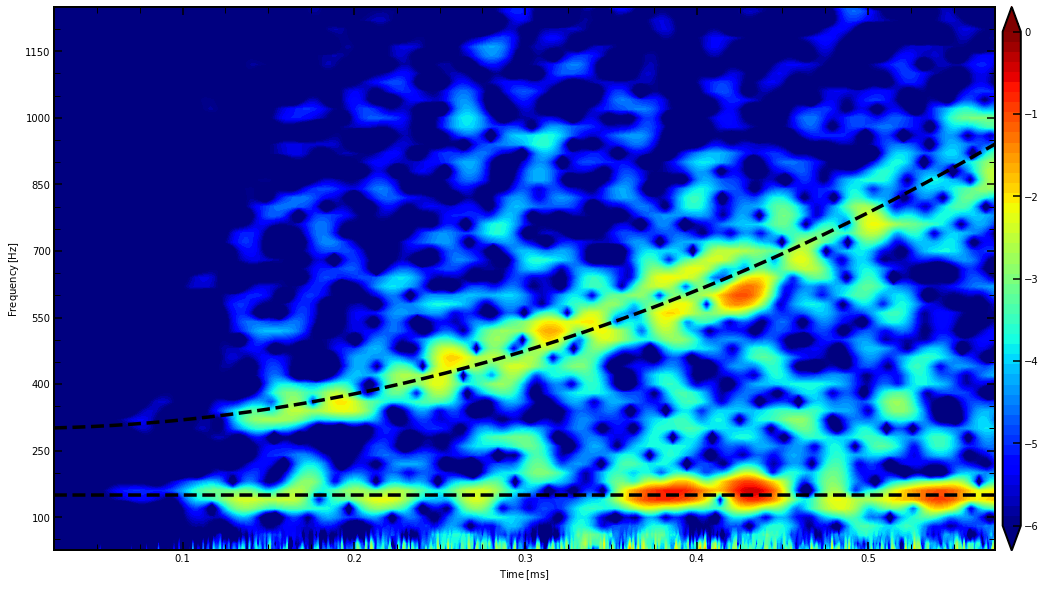

In [9]:
plot_signal(s.time,s.signal[0],s.signal[1])
plot_spectrogram(s.time,s.signal[0]/0.2,modes=modes) #Divide by 0.2 to make the plot pretty

# Using mode functions
The approach demonstrated here works for custom mode functions as well. 
To avoid placing strong constraints on user implemented mode functions, the inputs for mode functions
are passed through a `dict` called `mode_kw`. We use the same dict for all mode functions, but every function does not need to use all the elements in the `mode_kw`.

For example:

```python
def fmode(**kwargs): # We will pass mode_kw to this function
    msh = kwargs["msh"] #Here the function gets the input it needs from kwargs.
    rsh = kwargs["rsh"]
    b = 1.410e5
    c = -4.23e6

    x = np.sqrt(msh / rsh ** 3)
    f = b * x + c * x ** 2
    return f
```

## Inbuilt supernova specific modes
The modes included in the package take the properties of the supernova shock and PNS as input. If you are not familiar with supernova theory, think of these inputs as the underlying global properties of the physical system. 



In [9]:
#Data from a supernova simulation.
t,rsh,rpns,mpns,h = np.loadtxt('s20_reduced.dat', unpack=True)
#It is important that all of these have the same length.
# here h is the GW signal from the simulation, in other words what we want to mimic.

#Normalize the units to solar masses and km, required by the modes.
rsh = rsh/1e5
rpns = rpns/1e5
mpns = mpns/1.9891e33

#the code assumes equidistant time spacing so we need to interpolate the input first
n = 4000
t_eqdist = np.linspace(t[0],t[-1],n)
rsheq = np.interp(t_eqdist,t,rsh)
rpnseq = np.interp(t_eqdist,t,rpns)
mpnseq = np.interp(t_eqdist,t,mpns)
heq = np.interp(t_eqdist,t,h)


In [10]:
modes = ('g2mode','p1mode') #Select the modes we want

#Set up the dict that will pass the physical properties of the system to the mode functions
#Note, for simplicity we assume that the mass behind the shock is equal to the mass of the PNS.
#This is not important for the code example.

modekw = {"rsh" : rsheq,"rpns" : rpnseq, "mpns" : mpnseq, "msh" : mpnseq}
pol = {"p1mode" : ["unpolarised",np.pi/2,-1.0],"g2mode" : ["unpolarised",0,0]}

#Calculate the central frequency of the modes that the code will use, so that we can
#overplot it on the spectrogram. This is just to show the match an not part of normal
#signal generation
mode_list_for_spec =  {'g2mode' : mode_list.g2mode(**modekw),
                      'p1mode' : mode_list.p1mode(**modekw)}


In [11]:
s2 = synthgrav.Signal(time=t_eqdist,modes=modes,mode_kwargs = modekw,polarisation=pol)
s2.modes

{'g2mode': <function synthgrav.mode_list.g2mode(**kwargs)>,
 'p1mode': <function synthgrav.mode_list.p1mode(**kwargs)>}

In [12]:
s2.generate_signal() #Generate the signal

# Comparing to the simulation

Now that we have generated the signal based on the input from a real simulation, we can
compare it to the signal of the underlying simulation.

Below we plot the generated signal, the spectrogram of the generated signal, and the spectrogram of the
signal from the simulation. The two do not match perfectly, but they agree reasonably well. The reasons for the mismatch could be
  1. Uncertainty in the mode frequencies determined by Torres-Forné et al.
  2. Errors induced due to the exact definition of the proto-neutron star radius 
     (we use  dens < 1e11 g/cm3 here)
 

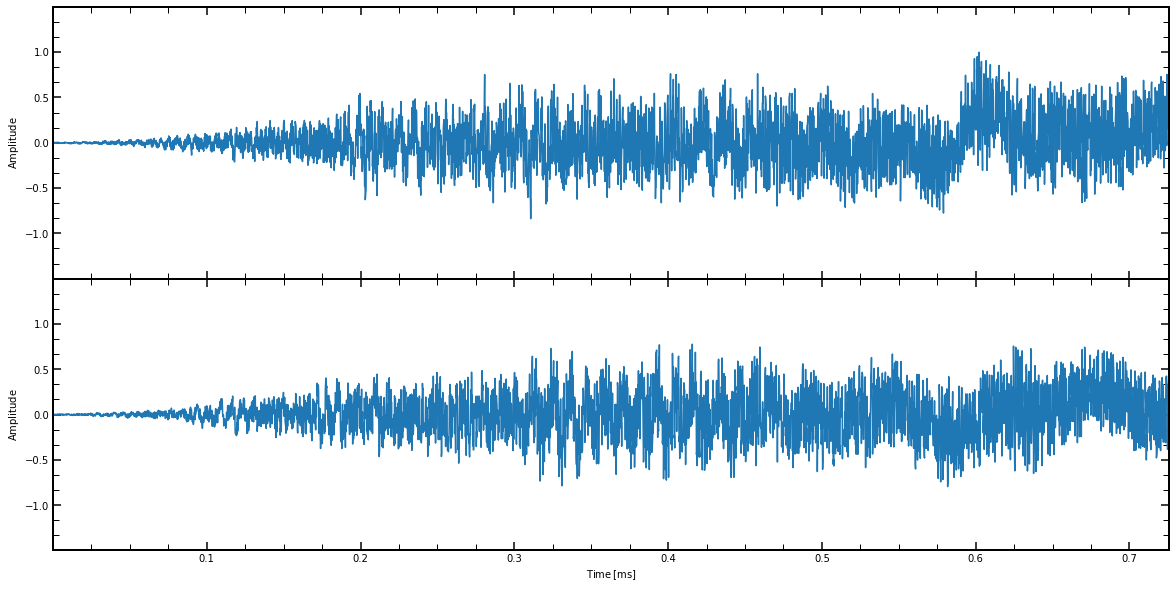

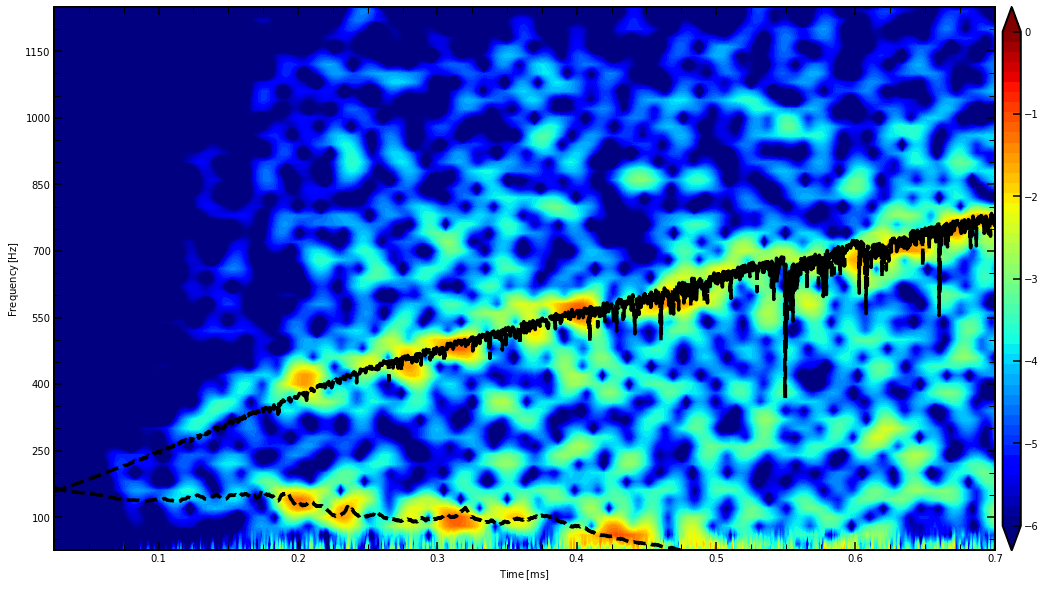

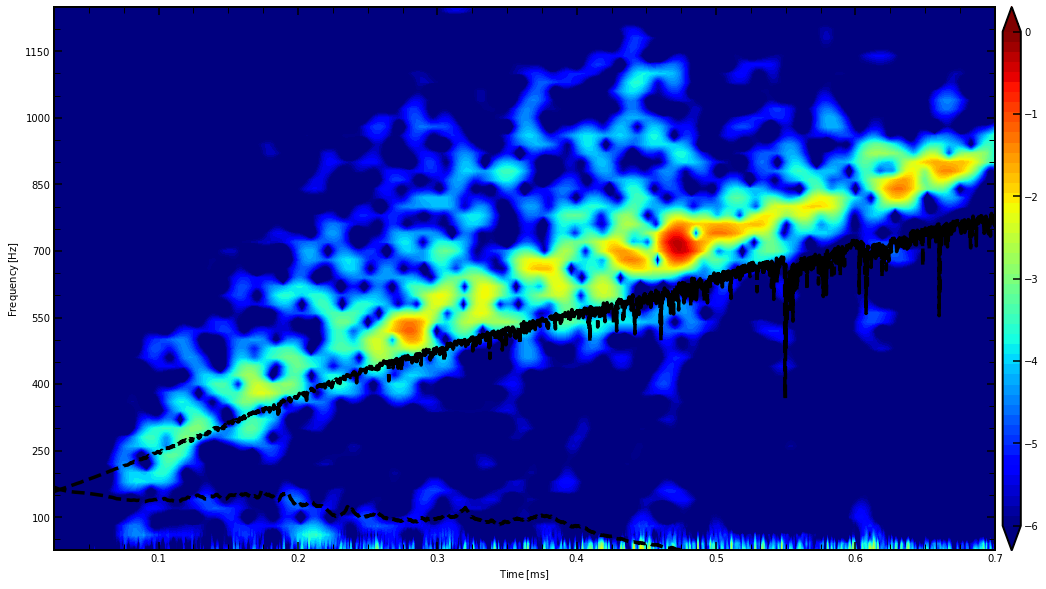

In [13]:
# Again, in the spectrograms we plot the expected central frequency from our mode functions.
plot_signal(s2.time,s2.signal[0],s2.signal[1])
plot_spectrogram(s2.time,s2.signal[0]/0.2,modes=mode_list_for_spec) #Divide by 0.2 to make the plot pretty
plot_spectrogram(t_eqdist,heq/0.2,modes=mode_list_for_spec) #Divide by 0.2 to make the plot pretty

# Mode weights
The signal we generated above has clear low-frequency modulations at late time. This happens because the frequency of the p1mode drastically decreases midway through the simulated time. The root cause is that, in the simulation, the model explodes. Once the model starts to explode, the shock radius increases rapidly.

It is expected that the p1mode should die down once the shock starts to expand; we can mimic this behaviour by adding a weight function to our mode. A simple choice would be a flipped sigmoid function.

Mode weights are passed through the `mode_weight` keyword as a dict and the keys of this dict must correspond to the name of a mode used for the signal.

Text(0, 0.5, 'amplitude')

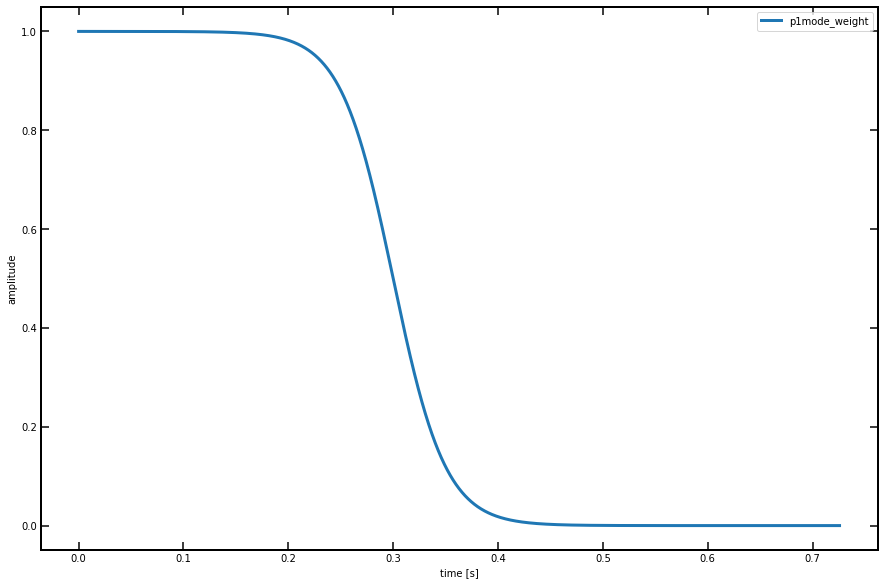

In [14]:
from scipy.special import expit as sigmoid
p1mode_weight = 1- sigmoid(40*(t_eqdist-0.3)) 
#40 and 0.3 are numbers that will adjust the shape and placement of the
#sigmoid function. 

#Lets plot the weight to make sure it looks resonable
f,ax=plt.subplots(figsize=(15,10),ncols=1,nrows=1,sharex="row",sharey="row")
ax.plot(t_eqdist,p1mode_weight,lw=3,label="p1mode_weight")
plt.legend()
ax.set_xlabel("time [s]")
ax.set_ylabel("amplitude")

In [15]:
#Set up the signal

modes = ('g2mode','p1mode') #Select the modes we want
#Set up the dict that will pass the physical properties of the system to the mode functions
#Note, for simplicity, we assume that the mass behind the shock equals the mass of the PNS.
#This is not important for the code example.
modekw = {"rsh" : rsheq,"rpns" : rpnseq, "mpns" : mpnseq, "msh" : mpnseq}
pol = {"p1mode" : ["unpolarised",0.0],"g2mode" : ["unpolarised",0]}

#This time we add a mode weight
mode_weight = {'p1mode' : p1mode_weight} #Notice that the key must match the mode name

In [17]:
s3 = synthgrav.Signal(time=t_eqdist,modes=modes,mode_kwargs = modekw,polarisation=pol, 
                             mode_weight=mode_weight)

In [18]:
s3.generate_signal()

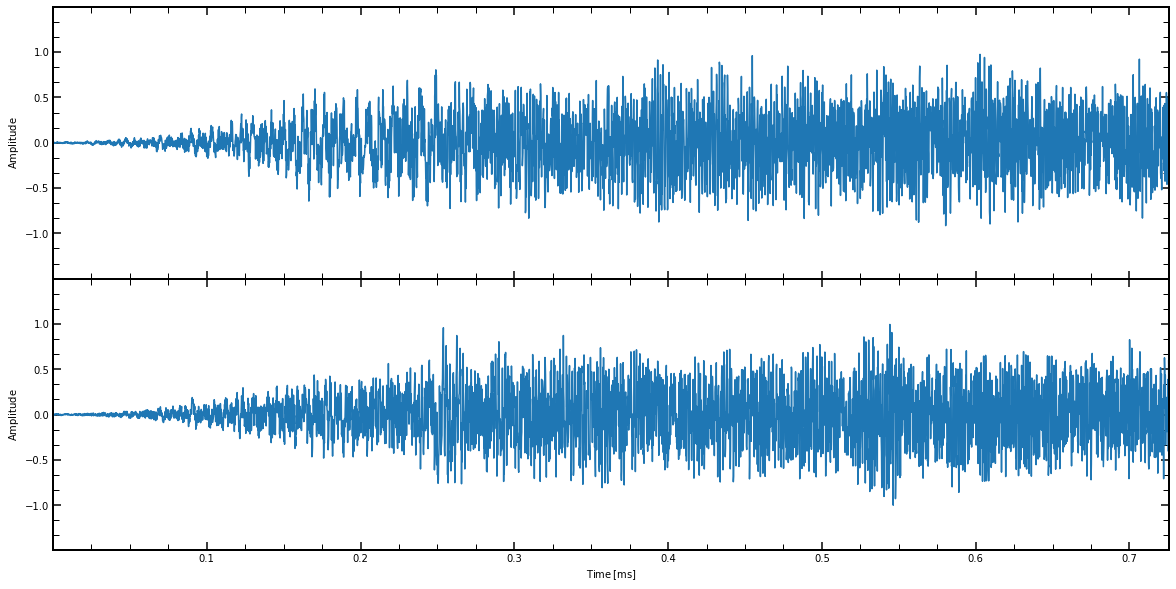

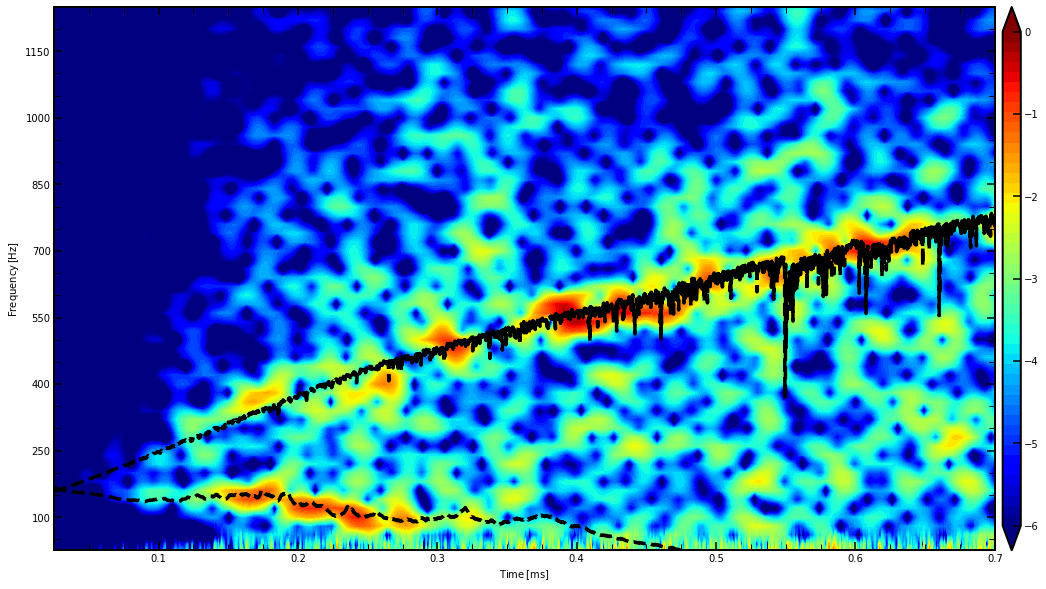

In [19]:
#Plot the signal
plot_signal(s3.time,s3.signal[0],s3.signal[1])
plot_spectrogram(s3.time,s3.signal[0]/0.2,modes=mode_list_for_spec)

### No low-frequency emission at late time
We now see that the low-frequency oscilations are gone and that the mode_weight has done its job. Such weights can be applied to any mode and can follow any temporal evolution.

## Saving the signal

There are two options for saving the signal

```python
signal.save_signal('filename')
```
saves the time, h1, and h2 to disk to the file filename.

```python
signal.save_all('filename')
```
saves the full signal information. In other words, the signal, individual modes, 
polarization information, and
the noise data.

In [20]:
s2.save_all('s2_full.txt')
s2.save_signal('s2_signal_only.txt')